# Vision Transformer

## Data

(1024, 1280)
[[0.05655709 0.05797101 0.06150583 ... 0.0077766  0.00600919 0.00636267]
 [0.06044539 0.06327324 0.06327324 ... 0.00848356 0.00600919 0.00671615]
 [0.07104984 0.07281725 0.06009191 ... 0.0077766  0.00600919 0.00565571]
 ...
 [0.05938494 0.06291976 0.0678685  ... 0.1417462  0.14033227 0.1378579 ]
 [0.06574761 0.06256628 0.06362672 ... 0.12972782 0.13220219 0.13573701]
 [0.05973842 0.05691057 0.05938494 ... 0.1223047  0.12301166 0.12831389]]
RGB aray shape (1024, 1280, 3)


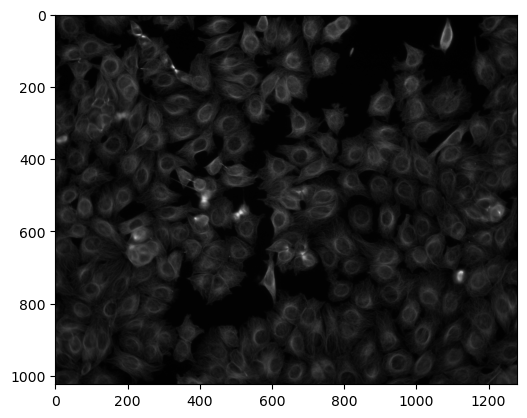

In [1]:
from PIL import Image
from tifffile import imread
import matplotlib.pyplot as plt
import os
import numpy as np

file_dir = '/mnt/custom-file-systems/efs/fs-0252e317d4af1dc34_fsap-0a708b50be80889d5/CLONED_REPOS/Computer-Vision/files/images/Week1_22123'

sample_image_array = imread(os.path.join(file_dir, os.listdir(file_dir)[0]))
print(sample_image_array.shape)
nrm_samp_img_arry = (sample_image_array-sample_image_array.min())/(sample_image_array.max()-sample_image_array.min())#*255

nrm_samp_img_arry.astype(np.uint8)
print(nrm_samp_img_arry)

rgb_array = np.stack((nrm_samp_img_arry,nrm_samp_img_arry,nrm_samp_img_arry), axis=-1)
print('RGB aray shape', rgb_array.shape)
plt.imshow(rgb_array)


## Patch Embeddings

In [3]:
import torch
import torch.nn as nn

## sample input ##
# print('input image shape:', multichannel_img.shape) ## would be 224 x 224 for vit
im = rgb_array.transpose(2, 1, 0) 
print('original numpy image dim:', im.shape)
tens = torch.tensor(im)
print('original tensor image dim:', tens.size())



## Create a projection layer ##
patch_size = 16
num_patches = (1080 // patch_size)**2 # (covers the area of the image)
print('Total number of patches created:', num_patches)

embed_dim = 768 #385 # embedding dimension, can be 768 for ViT-B/16
proj = nn.Conv2d(3, embed_dim, kernel_size=patch_size, stride=patch_size, bias=False) # extract non-overlapping patches of 16x16 pixels
proj.cuda()
tens = tens.unsqueeze(0).cuda()  
tens = tens.float() 
patch_emnedding = proj(tens)
print('patch embedding dim: (batch, channel, height, width)', patch_emnedding.shape)
print('flattened patch embedding dim: (batch, channels,length)', patch_emnedding.flatten(2).shape)
print('transposed patch embedding dim: (batch, channels, length)', patch_emnedding.flatten(2).transpose(1,2).shape)


original numpy image dim: (3, 1280, 1024)
original tensor image dim: torch.Size([3, 1280, 1024])
Total number of patches created: 4489
patch embedding dim: (batch, channel, height, width) torch.Size([1, 768, 80, 64])
flattened patch embedding dim: (batch, channels,length) torch.Size([1, 768, 5120])
transposed patch embedding dim: (batch, channels, length) torch.Size([1, 5120, 768])


## Multi Head Attention (MHA)

In [4]:
number_attn_heads = 12 # number of attention heads
attn_head_dim = embed_dim//number_attn_heads # dimension of each head (dim of vector it opperats on)
print('attention head dimension:', attn_head_dim)

attn_scale = attn_head_dim ** -0.5 # scaling factor for attention scores

print('embed_dim:', embed_dim)
qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False) # query, key, value projection

attn_drop_layer = nn.Dropout(0.1) # dropout layer for attention scores  = 0.

proj = nn.Linear(embed_dim, embed_dim) # final linear projection after attention = 0.
proj = proj.cuda()
proj_drop = nn.Dropout(p=0.1) # dropout layer after projection


attention head dimension: 64
embed_dim: 768


In [5]:
## create query, key , value projection ##

x = patch_emnedding.flatten(2).transpose(1,2)
x2 = patch_emnedding.flatten(2).transpose(1,2)
B,N,C = x.shape # batch, number of patches, embedding dimension
print('B (batch):', B, 'N (# patches):', N, 'C (emb_dimension):', C)
qkv.cuda()

qkv_vecs = qkv(x)
print('query, key, value projection (batch, # patches , 3xembed_dim):', qkv_vecs.shape) # apply linear projection to the input tensor

qkv_vecs_distributed = qkv_vecs.reshape(B, N, 3, number_attn_heads, attn_head_dim)
print('qkv projection reshaped: (batch, # patches, 3 "vectors", across x attention heads, with new dimension y)',qkv_vecs_distributed.shape) # reshape to (batch, num_patches, 3, num_heads, head_dim)

qkv_vecs_dist_reord = qkv_vecs_distributed.permute(2, 0, 3, 1, 4)
print('qkv projection permuted: (3 "vectors", batch, across x attention heads, # patches, with new dimension y)', qkv_vecs_dist_reord.shape) # permute to (3, batch, num_heads, num_patches, head_dim)

q, k, v = qkv_vecs_dist_reord[0], qkv_vecs_dist_reord[1], qkv_vecs_dist_reord[2]
print('query shape:', q.shape, 'key shape:', k.shape, 'value shape:', v.shape) # query, key, value shapes


B (batch): 1 N (# patches): 5120 C (emb_dimension): 768
query, key, value projection (batch, # patches , 3xembed_dim): torch.Size([1, 5120, 2304])
qkv projection reshaped: (batch, # patches, 3 "vectors", across x attention heads, with new dimension y) torch.Size([1, 5120, 3, 12, 64])
qkv projection permuted: (3 "vectors", batch, across x attention heads, # patches, with new dimension y) torch.Size([3, 1, 12, 5120, 64])
query shape: torch.Size([1, 12, 5120, 64]) key shape: torch.Size([1, 12, 5120, 64]) value shape: torch.Size([1, 12, 5120, 64])


In [6]:
k.shape

torch.Size([1, 12, 5120, 64])

In [7]:
q.shape

torch.Size([1, 12, 5120, 64])

In [8]:
## calculate attention on the q,k vectors ##
# q matrix multiplication (k) q:(RxC)(CxR):k -> RXR
attn = q @ k.transpose(-1,-2)
print('attention score matrx (batch, # attention heads, number query patches, number key patches): ',attn.shape)
# print(attn[0,0,0:5,0:5]) # print first 5x5 matrix of attention scores
# scale the attention scores
attn = attn * attn_scale
# print(attn[0,0,0:5,0:5]) # print first 5x5 matrix of scaled attention scores

attn = attn.softmax(dim=-1) # apply softmax to the attention scores
print('scaled attention score matrix (batch, # attention heads, number query patches, number key patches): ', attn.shape)
# print(attn[0,0,0:5,0:5]) # print first 5x5 matrix of attention scores after softmax 

# apply dropout to attention scores (regulization to prevent overfitting)
attn = attn_drop_layer(attn)





### FINAL patch EMBEDDING ### across all patches bassed on attention scores ## CONTEXT RICH embedding for ea patch###
x = (attn @ v).transpose(1,2).reshape(B, N, C) # reshape to (batch, num_patches, embed_dim) # apply attention to the value vectors (!!!!!acts as concatination of ea attention head output!!!!)
print('x shape after attention (batch, # patches, embed_dim) CONTEXT RICH EMBEDDINGS for ea patch:\n', x.shape) # x is the output of the attention layer



### Used to mix the information from all patches accross all attention heads ###
x = proj(x) # apply final linear projection 
print('x shape after final projection (batch, # patches, embed_dim):', x.shape) # x is the output of the attention layer after final projection
# print(x[0,0:5,:]) # print first 5 patches of the output of the attention layer after final projection
x = proj_drop(x) # apply dropout to the output of the attention layer
# print('x shape after dropout (batch, # patches, embed_dim):', x.shape) # x is the output of the attention layer after dropout
# print(x[0,0:5,:]) # print first 5 patches of the output of the attention layer after dropout

# print(f' input:{x[0,0:5,:]},attention score: {attn[0,0,0:5,0:5]}, query: {q}, key: {k}, value: {v}')

attention score matrx (batch, # attention heads, number query patches, number key patches):  torch.Size([1, 12, 5120, 5120])
scaled attention score matrix (batch, # attention heads, number query patches, number key patches):  torch.Size([1, 12, 5120, 5120])
x shape after attention (batch, # patches, embed_dim) CONTEXT RICH EMBEDDINGS for ea patch:
 torch.Size([1, 5120, 768])
x shape after final projection (batch, # patches, embed_dim): torch.Size([1, 5120, 768])


In [9]:
v.shape

torch.Size([1, 12, 5120, 64])

In [10]:
(attn @ v).shape # apply attention to the value vectors

torch.Size([1, 12, 5120, 64])

In [11]:
(attn @ v).transpose(1,2).reshape(B, N, C).shape # reshape to (batch, num_patches, embed_dim) concatinates embeddings from all attention heads

torch.Size([1, 5120, 768])

## DropPath

In [ ]:
drop_path_rate = 0.1
drop_path_lst = [x.item() for x in torch.linspace(0, drop_path_rate, 12)]
drop_path_lst

In [ ]:
drop_prob = drop_path_lst[2]
drop_probability = drop_prob

training = False # set to True if you want to apply dropout, False if you want to use the model for inference

if drop_probability == 0. or not training:
    x = x


#### creates the mask to randomly drop patches  ####
keep_prob = 1. - drop_probability
print(keep_prob) # this is the probability of keeping the neuron active

shape = (x.shape[0],) + (1,) * (x.ndim-1) # this is the shape of the tensor after dropout 
print(shape) # shape of the tensor after dropout, (batch, 1, 1) for a single batch

rnd_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device) # this is the random tensor used for dropout (mask)
print(rnd_tensor.shape) # shape of the random tensor used for dropout, (batch, 1, 1) for a single batch

print(rnd_tensor)

rnd_tensor.floor_() # modifies the values in-place of the original tensor ### (binarizes the tensor) ###
print(rnd_tensor) # this is the random tensor used for dropout after applying floor operation, it will be 0 or 1
print(x.shape)
print('\n')
####

# patch embeddings #
out = x.div(keep_prob)*rnd_tensor # this is the output of the dropout layer, it will be 0 or the original value divided by the keep probability

print(out.shape) # shape of the output of the dropout layer, (batch, # patches, embed_dim) for a single batcho

print(out[0,0:5,:]) # print first 5 patches of the output of the dropout layer

In [ ]:
rnd_tensor

In [ ]:
x.div(0.8)

In [ ]:
nn.Identity()

## Residual Layer

In [ ]:
x

In [ ]:
resd_x = x+out
resd_x

## NormLayer

In [ ]:
norm_layer = nn.LayerNorm(embed_dim) # create a layer normalization layer
norm_layer

In [ ]:
# applied before attention

norm_layer = norm_layer.cuda() # move the layer normalization layer to the GPU
# norm_layer(x2)
norm_layer(resd_x)

In [ ]:
print(x2.shape)
(x2 - torch.mean(x2,dim=2,keepdim=True))/torch.std(x2,dim=2,keepdim=True)

In [ ]:
norm_x = norm_layer(x)
print(norm_x.shape)

## MLP

In [ ]:
out_f = None
in_f = embed_dim
hidden_f = int(embed_dim*4)
out_feat = out_f or in_f

# Higer dimension projection
fc1 = nn.Linear(in_f, hidden_f)
fc1 = fc1.cuda()
act_layer = nn.GELU()
# project back to original dimension after
fc2 = nn.Linear(hidden_f, out_feat)
fc2 = fc2.cuda()
drop = nn.Dropout(0.) # dropout layer after the final linear projection


In [ ]:
## Mixing information between embeddings after mixing across heads ##
mlpx = fc1(x)
mlpx = act_layer(mlpx) # apply activation function
mlpx = drop(mlpx) # apply dropout
mlpx = fc2(mlpx)
mlpx = drop(mlpx) # apply dropout again
print(mlpx.shape) # shape of the output of the mlpx layer, (batch, # patches, embed_dim) for a single batch
mlpx

In [ ]:
norm_x.shape

In [ ]:
norm_x[:,0].shape